# Todo
## Evaluate the prediction
- [x] Join the ground truth data
- [x] Calculate the error/difference
- [x] Plot line charts with the ground truth

# Dependency

In [2]:
import pandas as pd

# Load Data
## Load predict data

In [38]:
predict = pd.read_csv('result/predict/南瓜-木瓜形_平均價_pred_week.csv')
# remove 2020
predict = predict[(predict['ds'] < '2020-01-01')]
predict = predict[['ds', 'yhat']]
predict = predict.rename(columns={'ds': 'DateTime', 'yhat': 'predict'})
predict['DateTime'] = pd.to_datetime(predict['DateTime'])

## Load the ground truth

In [10]:
USED_CROPS = ['鳳梨-金鑽鳳梨', '香蕉', '青蔥-日蔥', '蓮霧-紅蓮霧', '芽菜類-黃豆牙', '南瓜-木瓜形', '大蒜-蒜仁', '小白菜-土白菜', '木瓜-網室紅肉', '洋香瓜-網狀紅肉']

gt_df = pd.read_csv('data/test.csv')
gt_df = gt_df.loc[gt_df['市場名稱'] == '台北一']
gt_df = gt_df[gt_df['作物名稱'].isin(USED_CROPS)]

## Select the specific crop

In [11]:
group_gt = gt_df.groupby(gt_df.作物名稱)

In [16]:
pumpkin = group_gt.get_group('南瓜-木瓜形')
pumpkin = pumpkin[['平均價', 'DateTime']]
pumpkin['DateTime'] = pd.to_datetime(pumpkin['DateTime'])

# Join the ground-truth & prediction

In [39]:
# pumpkin.join(predict, (pumpkin['DateTime'] == predict['ds']), 'inner')
result = pumpkin.merge(predict, on='DateTime')

## Calculate the difference

In [49]:
result['diff'] = result.apply(lambda row: abs(row['平均價'] - row['predict']), axis=1)

# Plot line charts with the ground truth

In [45]:
import plotly.io as pio
pio.renderers.default = 'svg'

In [ ]:
import plotly.graph_objects as go

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=result['DateTime'], y=result['平均價'],
                    mode='lines',
                    name='平均價'))
fig.add_trace(go.Scatter(x=result['DateTime'], y=result['predict'],
                    mode='lines',
                    name='預測'))

fig.show()

# Evaluator: Wrap all above processes

In [87]:
class Evaluator:
  def __init__(self, ground_truth):
    self.USED_CROPS = ['鳳梨-金鑽鳳梨', '香蕉', '青蔥-日蔥', '蓮霧-紅蓮霧', '芽菜類-黃豆牙', '南瓜-木瓜形', '大蒜-蒜仁', '小白菜-土白菜', '木瓜-網室紅肉', '洋香瓜-網狀紅肉']
    self.gt = self.load_gt(ground_truth)

  def load_gt(self, gt_file):
    gt_df = pd.read_csv(gt_file)
    gt_df = gt_df.loc[gt_df['市場名稱'] == '台北一']
    gt_df = gt_df[gt_df['作物名稱'].isin(USED_CROPS)]
    gt_df = gt_df.groupby(gt_df.作物名稱)
    return gt_df
    
  def load_predict(self, pred_file, name, target):
    predict = pd.read_csv(pred_file)
    predict = predict[(predict['ds'] < '2020-01-01')] # remove 2020
    predict = predict[['ds', 'yhat']]
    predict = predict.rename(columns={'ds': 'DateTime', 'yhat': 'predict'})
    predict['DateTime'] = pd.to_datetime(predict['DateTime'])
    self.predict = predict
    self.pred_class = name
    self.target = target
    
  def join(self):
    # select data of the predict class
    gt = self.gt.get_group(self.pred_class)
    gt = gt[[self.target, 'DateTime']]
    gt['DateTime'] = pd.to_datetime(gt['DateTime'])
    # join the ground-truth & prediction
    self.result = gt.merge(self.predict, on='DateTime')
    # calculate the difference
    self.result['diff'] = self.result.apply(lambda row: abs(row[self.target] - row['predict']), axis=1)

  def save(self, extra_tag=''):
    self.result.to_csv(f'result/result_csv/{self.pred_class}_{self.target}{extra_tag}.csv')
    self.fig.write_image(f'result/result_img/{self.pred_class}_{self.target}{extra_tag}.png')
    
  def plot(self, y_title='', extra_tag=''):
    # Create traces
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=self.result['DateTime'], y=self.result[self.target],
                        mode='lines',
                        name=self.target))
    fig.add_trace(go.Scatter(x=self.result['DateTime'], y=self.result['predict'],
                        mode='lines',
                        name='預測'))
    fig.update_layout(
      title = f'{self.pred_class} {self.target} 預測{extra_tag} - 2019',
      xaxis_title = "Date",
      yaxis_title = y_title,
      width=800,
      height=500
    )

    self.fig = fig
    fig.show()

## Evaluator - Sample Usage

In [86]:
# evl = Evaluator('data/test.csv')
# evl.load_predict('result/predict/南瓜-木瓜形_平均價_full_pred_week.csv', name='南瓜-木瓜形', target='平均價')
# evl.join()
# evl.plot(y_title='價格 (元)')
# evl.save(extra_tag='_full')

# Plot the results of all the crops

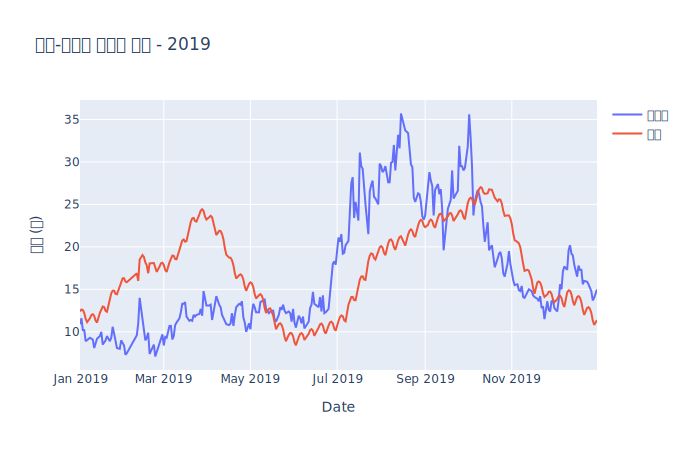

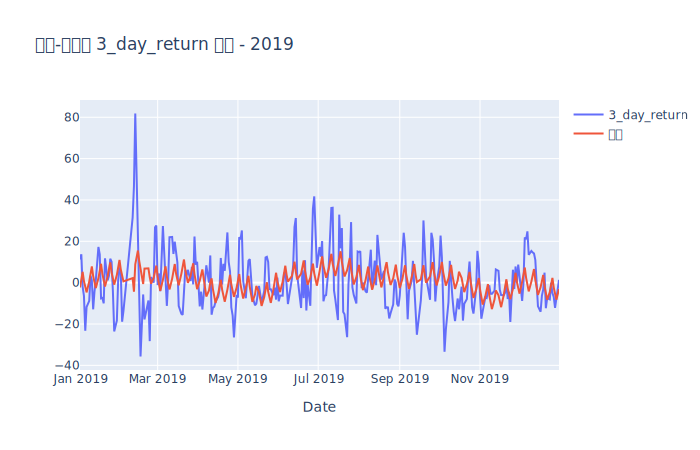

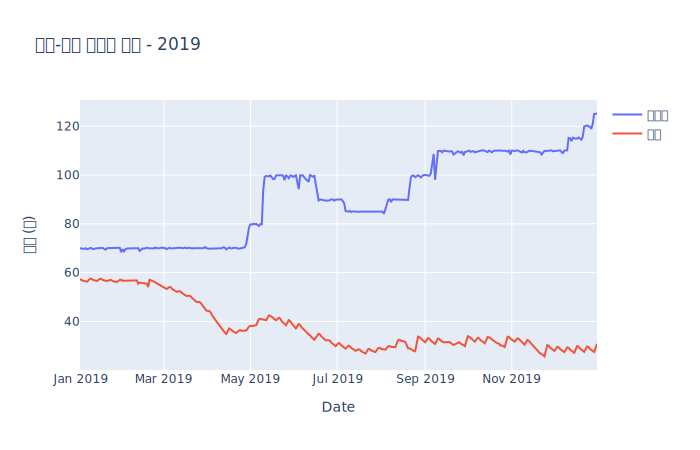

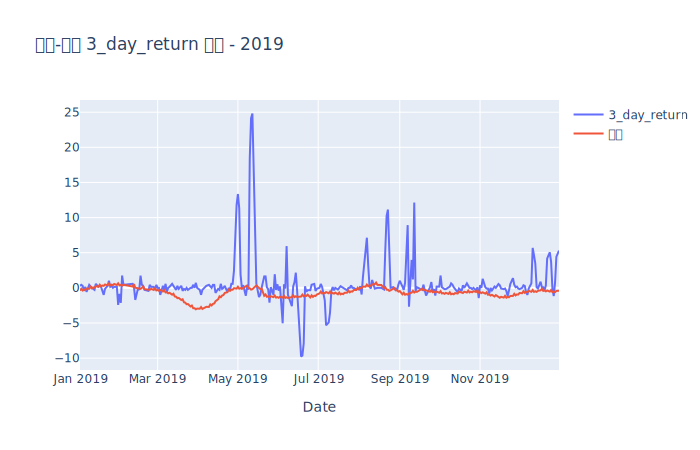

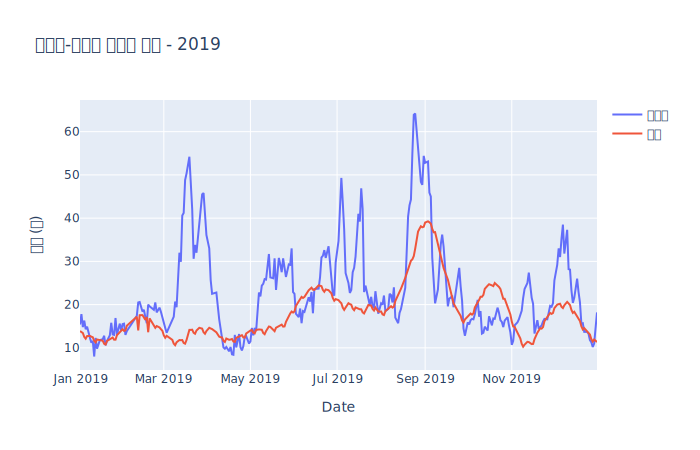

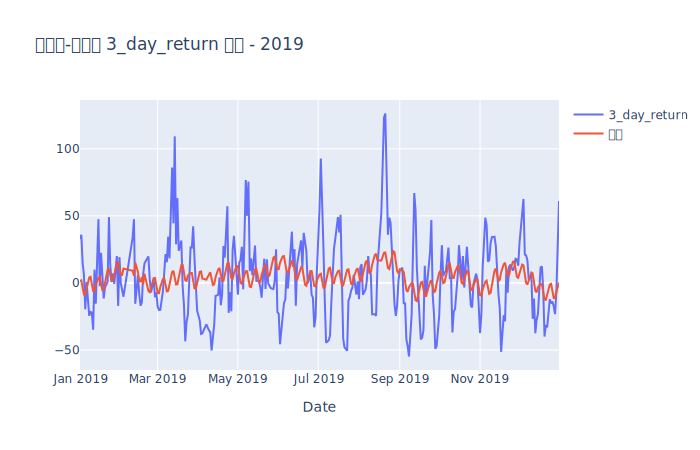

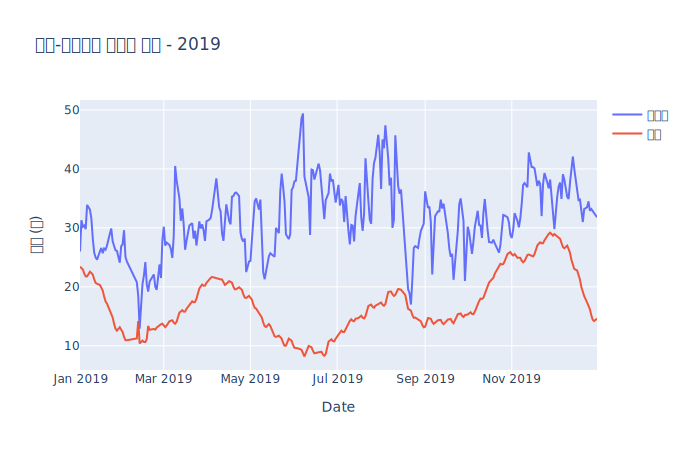

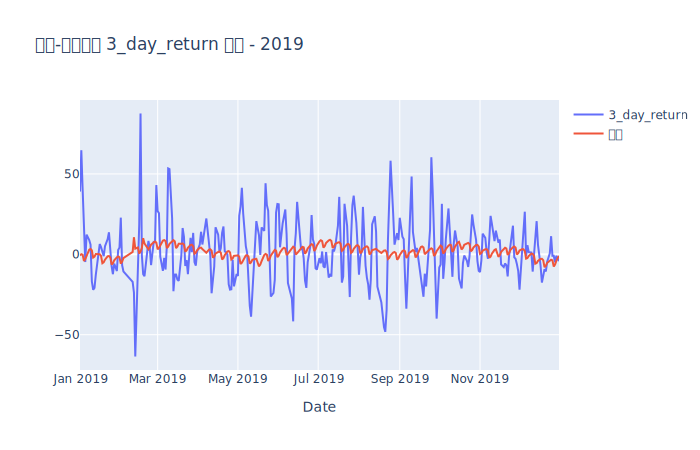

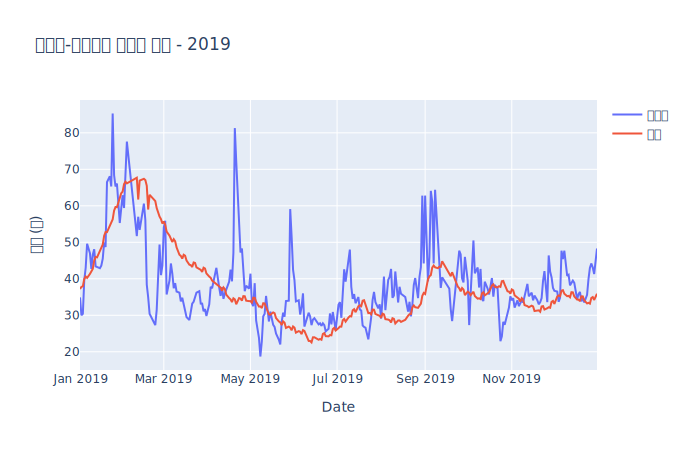

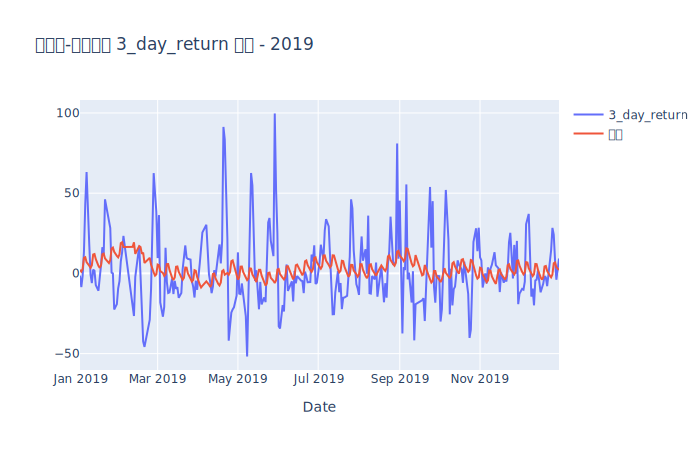

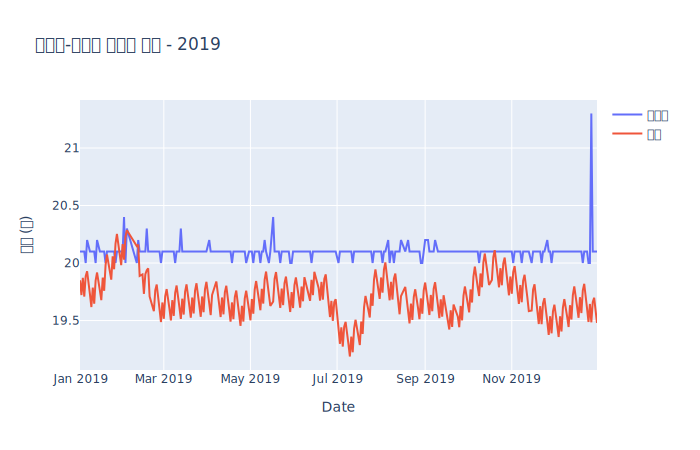

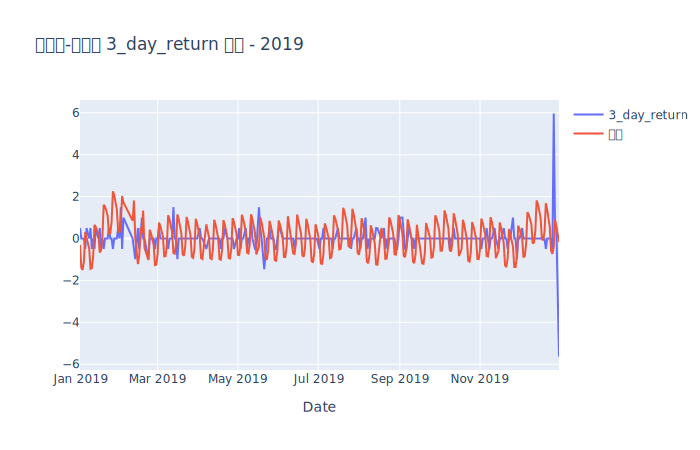

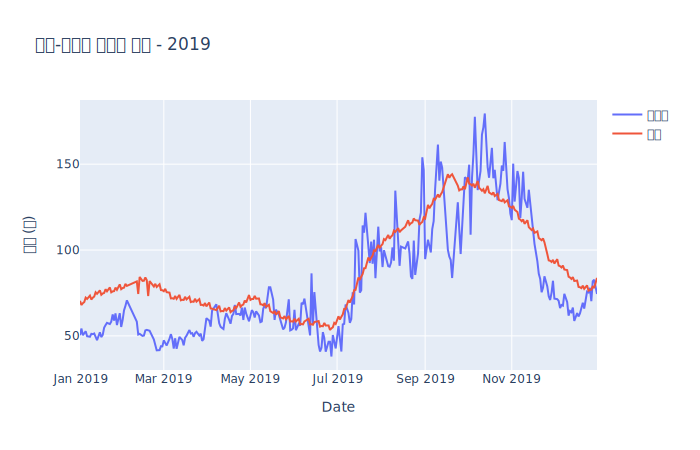

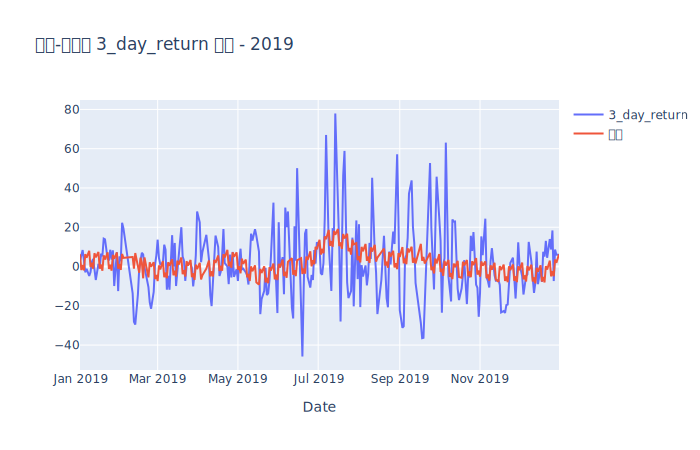

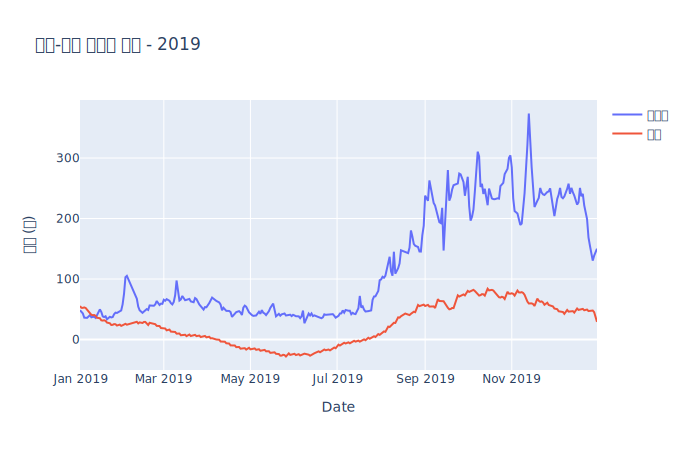

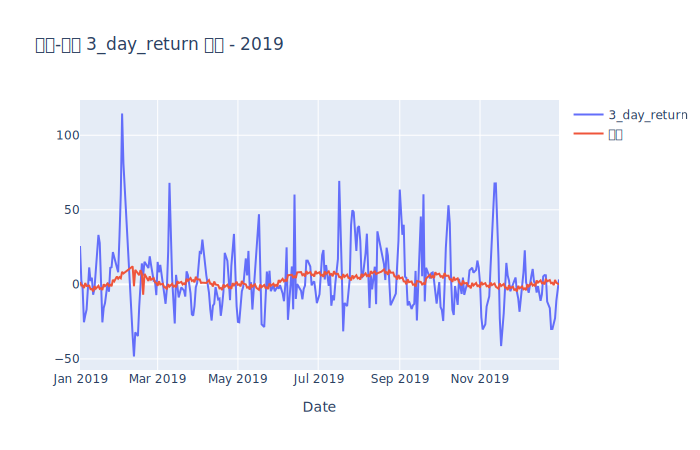

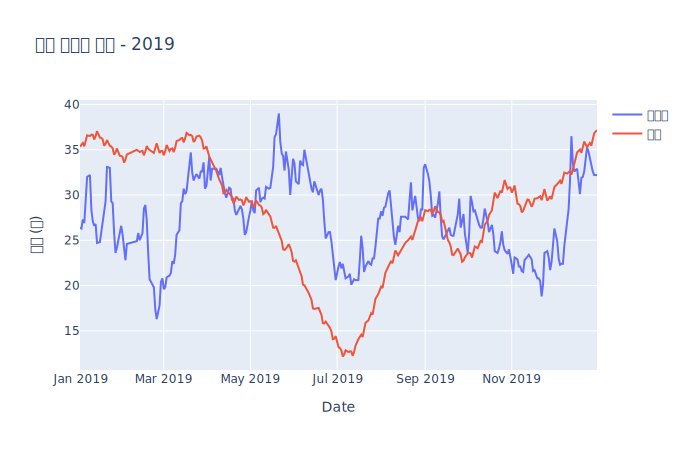

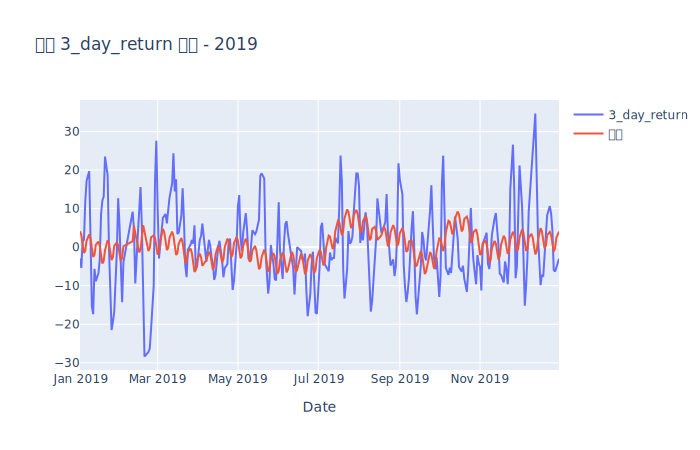

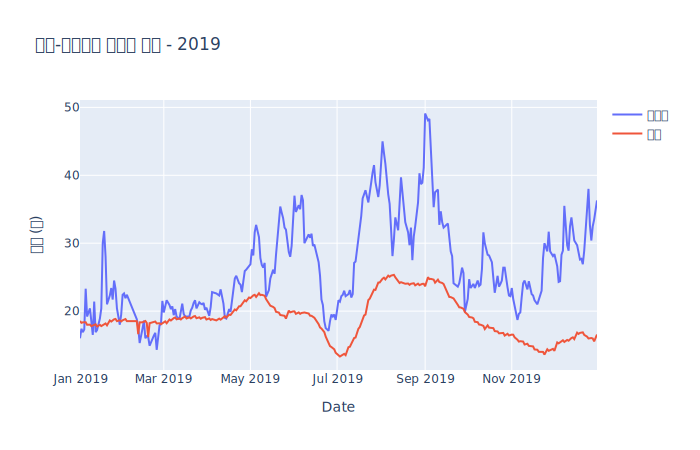

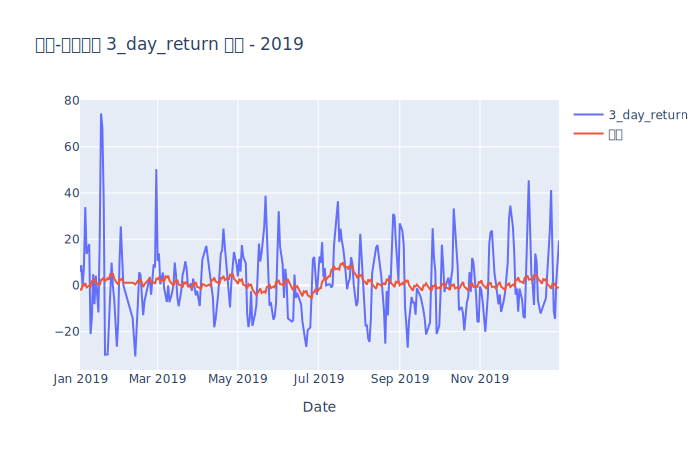

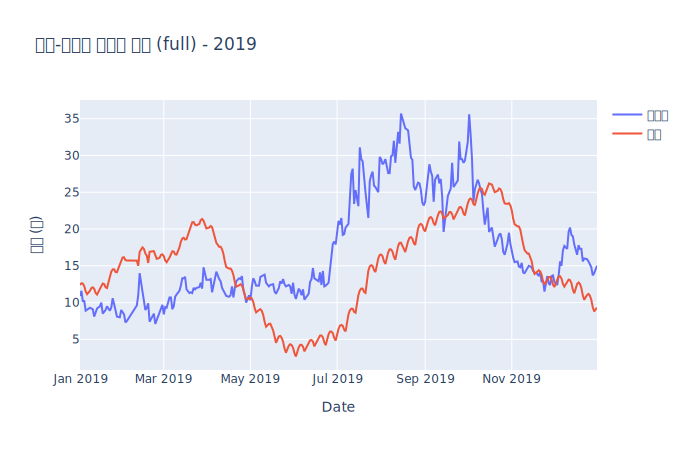

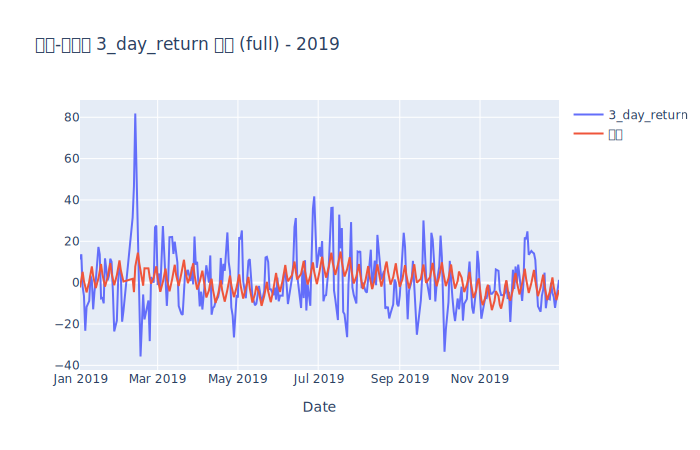

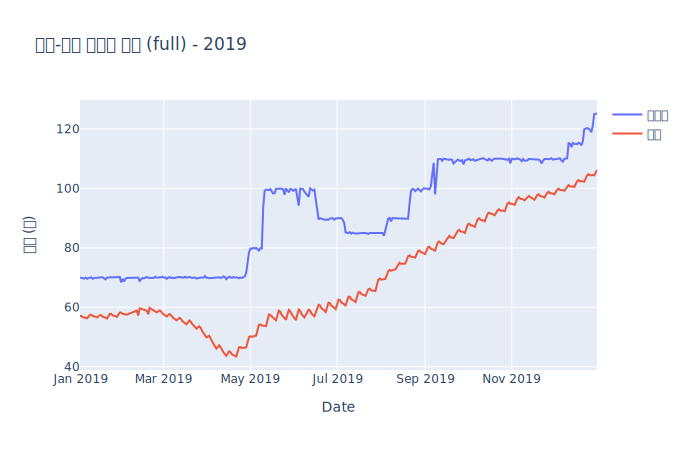

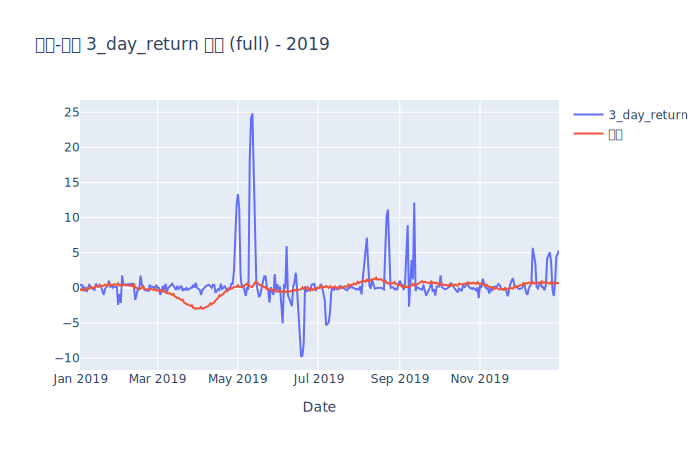

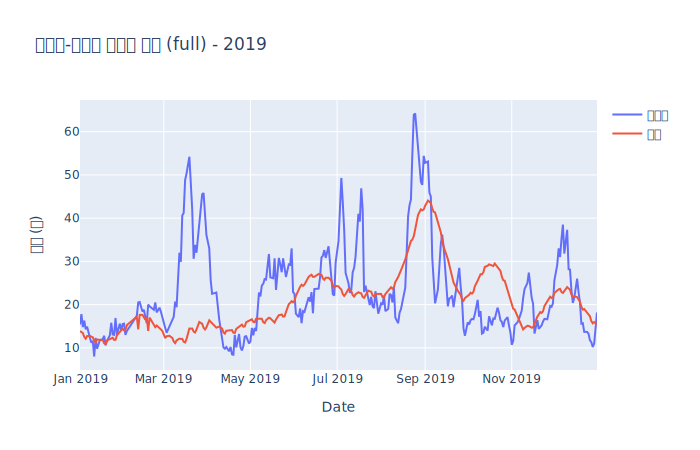

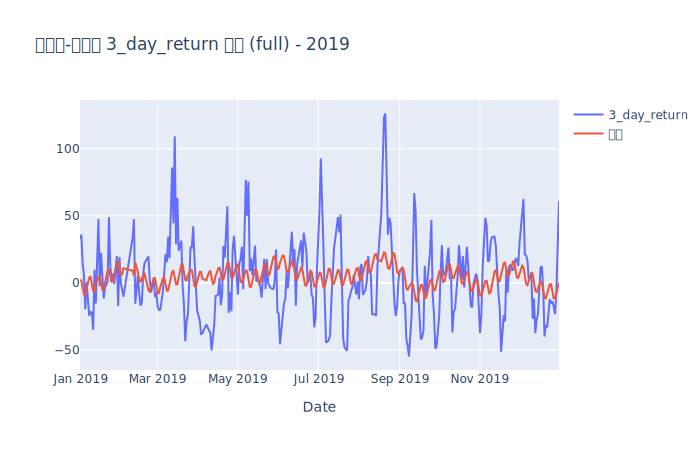

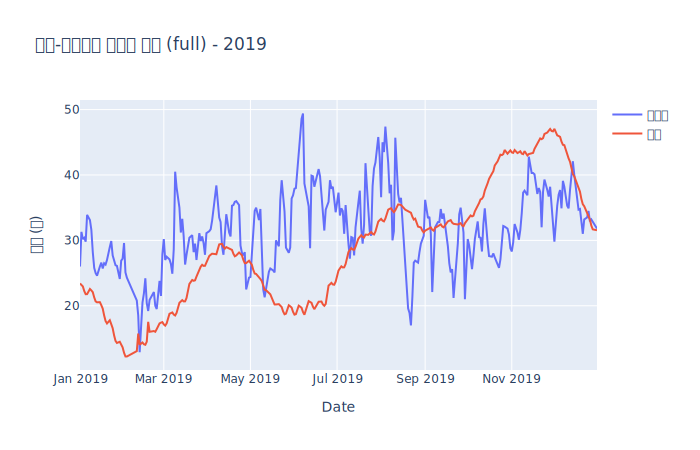

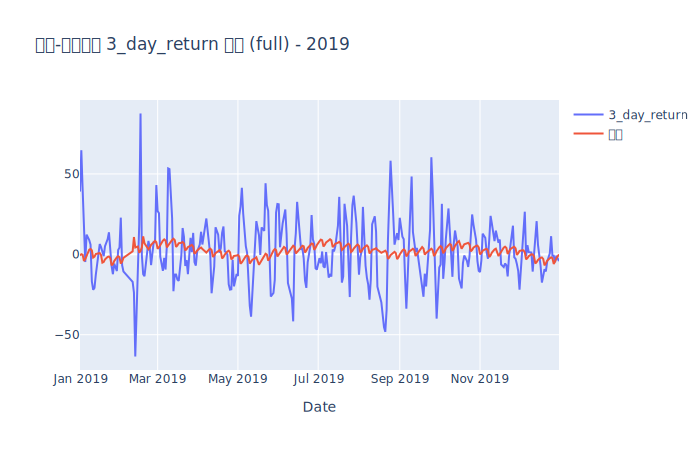

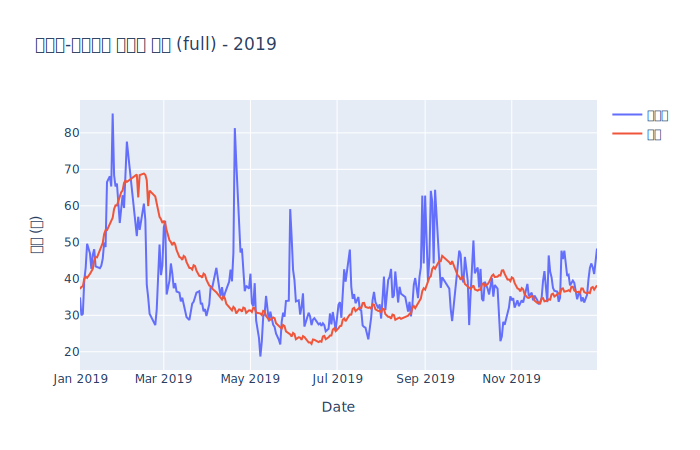

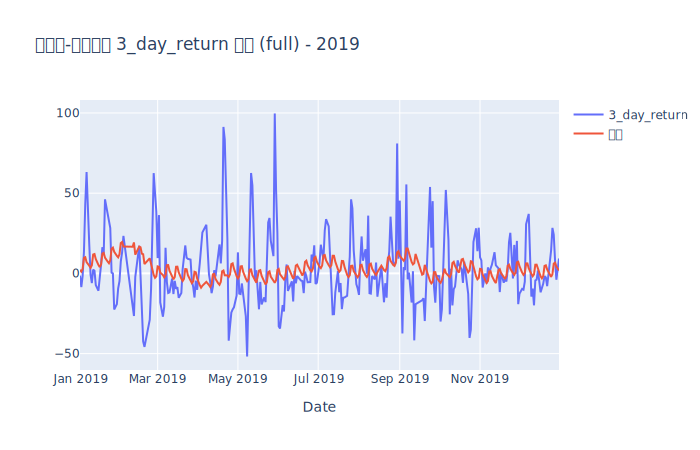

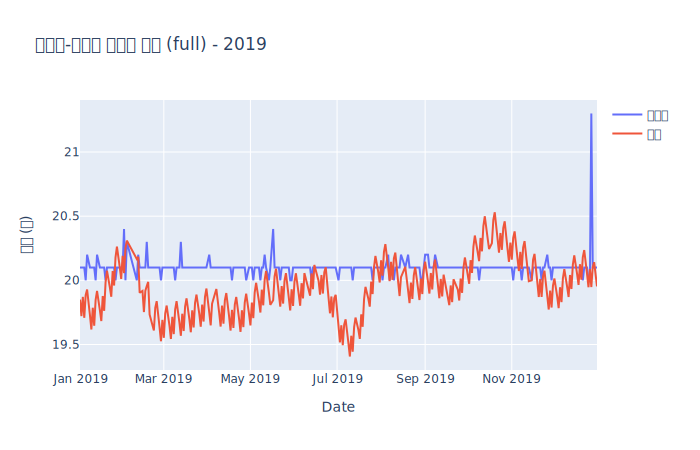

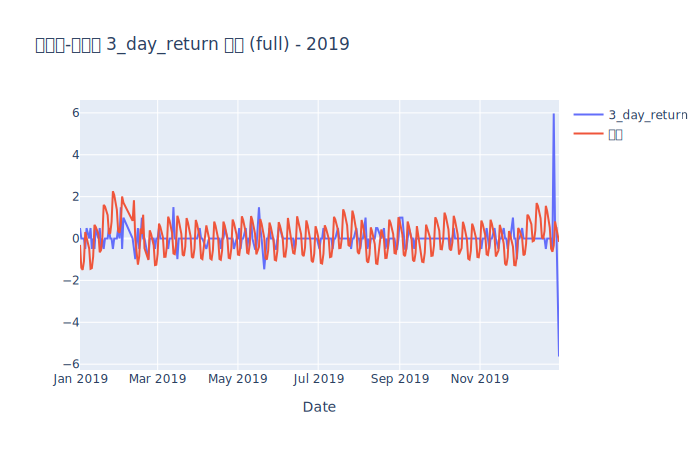

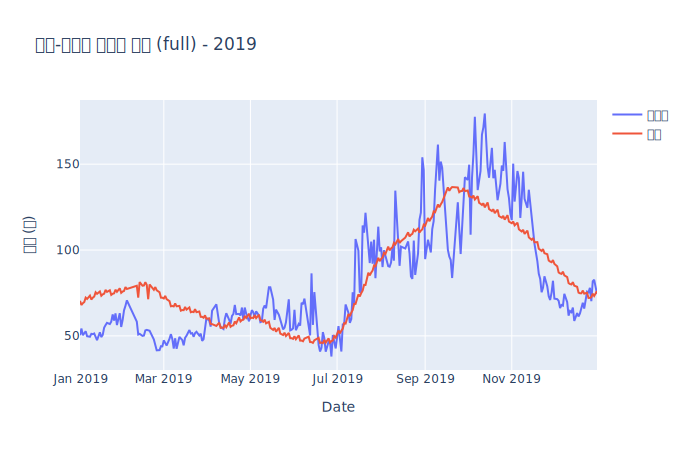

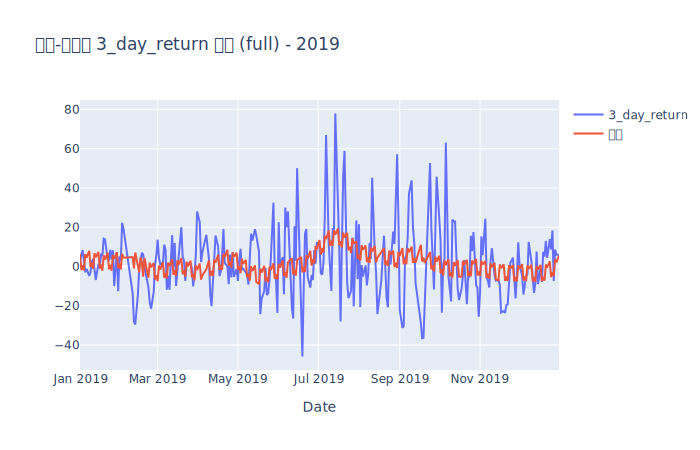

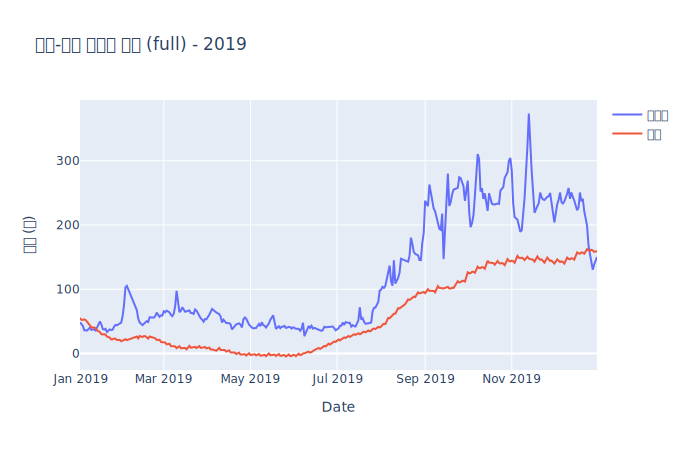

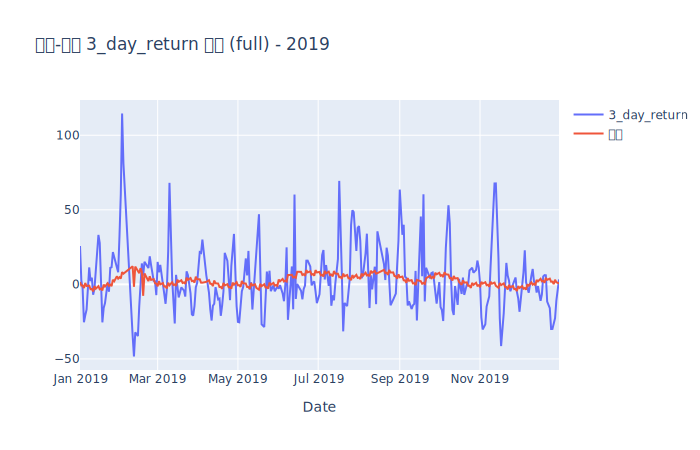

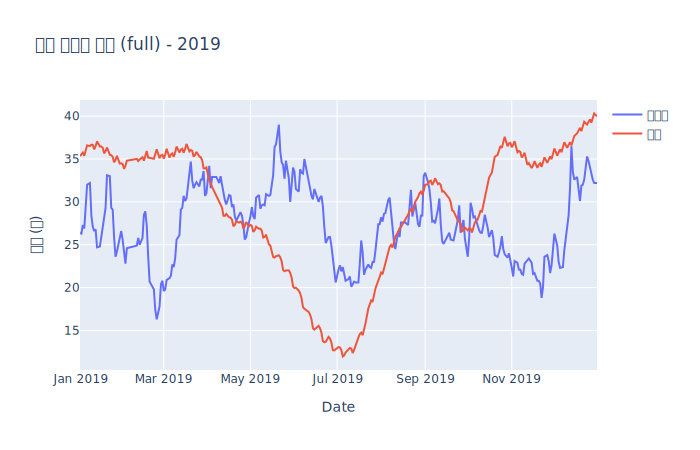

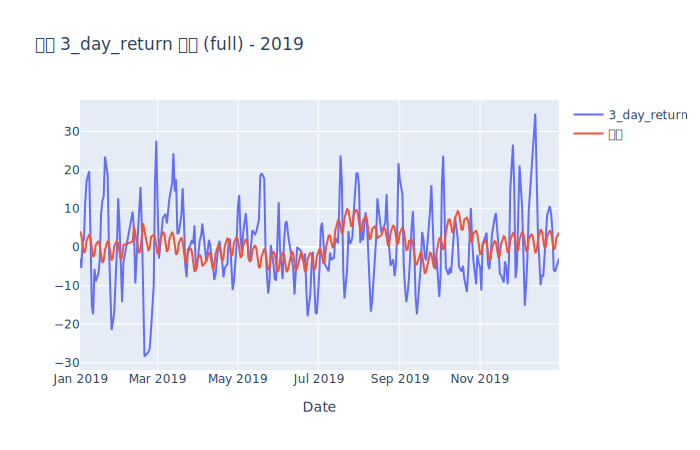

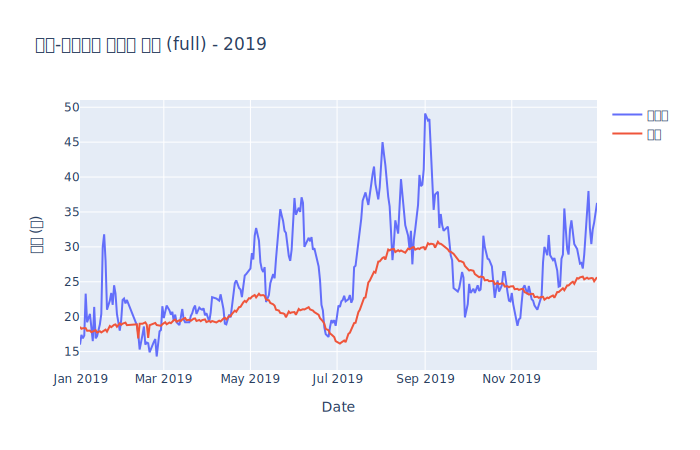

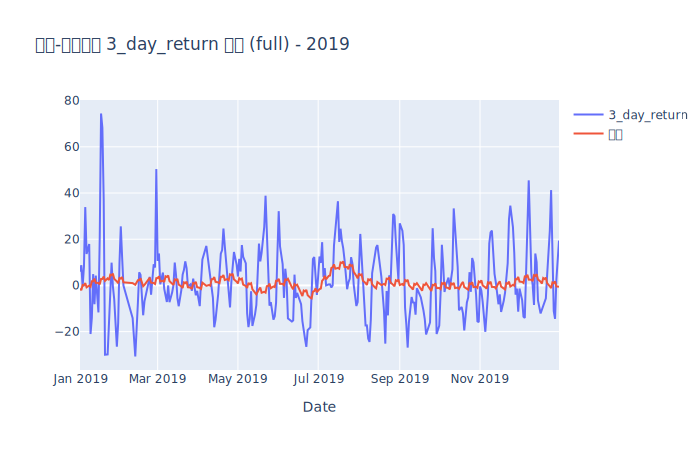

In [89]:
import os
from tqdm.notebook import tqdm

evl = Evaluator('data/test.csv')

pbar = tqdm(total=len(os.listdir('result/predict')))
for f in os.listdir('result/predict'):
#   print(f"# {f}")
  name = f.split('_')[0]
  
  if '平均價' in f:
    target = '平均價'
    y_title = '價格 (元)'
  elif '3_day_return' in f:
    target = '3_day_return'
    y_title = ''

  extra_tag = ' (full)' if 'full' in f else ''
  
  evl.load_predict(f'result/predict/{f}', name=name, target=target)
  evl.join()
  evl.plot(y_title=y_title, extra_tag=extra_tag)
  evl.save(extra_tag=extra_tag)
  
  pbar.update(1)

pbar.close()
        
#   if full in f:
#     print()
